In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


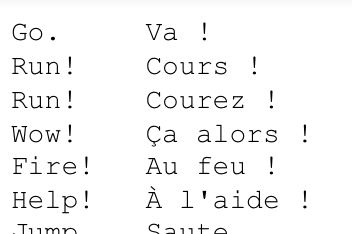

# 1) Load data & Preprocessing data

In [4]:
SOS_token = 0
EOS_token = 1

# word2index / index2word dictionary를 만들어줌
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# 파일은 유니코드로 되어있어서 간단하게 하기위해 아스키코드로 변환해줌
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
# 데이터를 라인별로 split해줌 그리고 영어+타국어로 1쌍을 만들어줌

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('/content/gdrive/MyDrive/Colab Notebooks/Data/seq2att/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
# 최대길이를 10으로 제한하고, 아포스트로피를 대체

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
'''
데이터 준비를 위한 전체 과정:

텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.
텍스트를 정규화 하고 길이와 내용으로 필터링 합니다.
쌍을 이룬 문장들로 단어 리스트를 생성합니다.
'''

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['vous n y allez pas si ?', 'you re not going are you ?']


        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

In [9]:
print("input_lang name:", input_lang.name)
print("word2index: \n",input_lang.word2index)
print("word2count: \n",input_lang.word2count)
print("n_words:",input_lang.n_words)

input_lang name: fra
word2index: 
 {'j': 2, 'ai': 3, 'ans': 4, '.': 5, 'je': 6, 'vais': 7, 'bien': 8, 'ca': 9, 'va': 10, 'suis': 11, 'gras': 12, 'gros': 13, 'en': 14, 'forme': 15, 'touche': 16, '!': 17, 'touchee': 18, 'malade': 19, 'triste': 20, 'timide': 21, 'mouille': 22, 'mouillee': 23, 'il': 24, 'est': 25, 'revenu': 26, 'me': 27, 'revoila': 28, 'chauve': 29, 'occupe': 30, 'occupee': 31, 'calme': 32, 'froid': 33, 'fini': 34, 'tout': 35, 'libre': 36, 'disponible': 37, 'repu': 38, 'rassasie': 39, 'content': 40, 'chez': 41, 'moi': 42, 'retard': 43, 'paresseux': 44, 'faineant': 45, 'paresseuse': 46, 'faineante': 47, 'porte': 48, 'securite': 49, 'certain': 50, 'sur': 51, 'sure': 52, 'grande': 53, 'mince': 54, 'ordonne': 55, 'ordonnee': 56, 'laid': 57, 'laide': 58, 'faible': 59, 'vieux': 60, 'dj': 61, 'bon': 62, 'riche': 63, 'ici': 64, 'flic': 65, 'un': 66, 'homme': 67, 'seule': 68, 'seul': 69, 'arme': 70, 'armee': 71, 'reveille': 72, 'aveugle': 73, 'fauche': 74, 'fou': 75, 'folle': 76, '

In [10]:
print("output_lang name:", output_lang.name)
print("word2index: \n",output_lang.word2index)
print("word2count: \n",output_lang.word2count)
print("n_words:",output_lang.n_words)

output_lang name: eng
word2index: 
 {'i': 2, 'm': 3, '.': 4, 'ok': 5, 'fat': 6, 'fit': 7, 'hit': 8, '!': 9, 'ill': 10, 'sad': 11, 'shy': 12, 'wet': 13, 'he': 14, 's': 15, 'am': 16, 'back': 17, 'bald': 18, 'busy': 19, 'calm': 20, 'cold': 21, 'done': 22, 'fine': 23, 'free': 24, 'full': 25, 'glad': 26, 'home': 27, 'late': 28, 'lazy': 29, 'okay': 30, 'safe': 31, 'sick': 32, 'sure': 33, 'tall': 34, 'thin': 35, 'tidy': 36, 'ugly': 37, 'weak': 38, 'well': 39, 'is': 40, 'old': 41, 'a': 42, 'dj': 43, 'good': 44, 'rich': 45, 'here': 46, 'cop': 47, 'man': 48, 'alone': 49, 'armed': 50, 'awake': 51, 'blind': 52, 'broke': 53, 'crazy': 54, 'cured': 55, 'drunk': 56, 'dying': 57, 'early': 58, 'first': 59, 'fussy': 60, 'going': 61, 'loyal': 62, 'lucky': 63, 'lying': 64, 'quiet': 65, 'ready': 66, 'right': 67, 'sober': 68, 'sorry': 69, 'stuck': 70, 'timid': 71, 'tired': 72, 'tough': 73, 'yours': 74, 'she': 75, 'hot': 76, 'we': 77, 're': 78, 'kind': 79, 'poor': 80, 'swiss': 81, 'smart': 82, 'human': 83, 'f

In [11]:
print("[[ FRA / ENG ]]")
print("pairs len : {}\n".format(len(pairs)))
for i in pairs[:10]:
  print(i)

[[ FRA / ENG ]]
pairs len : 10599

['j ai ans .', 'i m .']
['je vais bien .', 'i m ok .']
['ca va .', 'i m ok .']
['je suis gras .', 'i m fat .']
['je suis gros .', 'i m fat .']
['je suis en forme .', 'i m fit .']
['je suis touche !', 'i m hit !']
['je suis touchee !', 'i m hit !']
['je suis malade .', 'i m ill .']
['je suis triste .', 'i m sad .']


# 2) Seq2Seq modeling

### Encoder
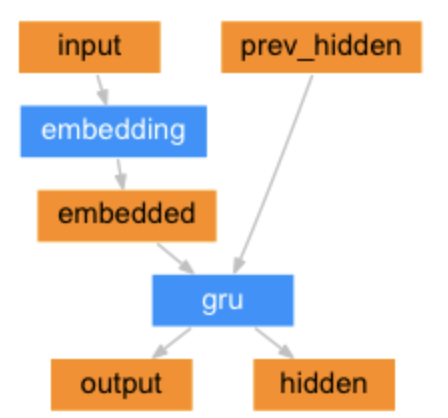

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # Layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder
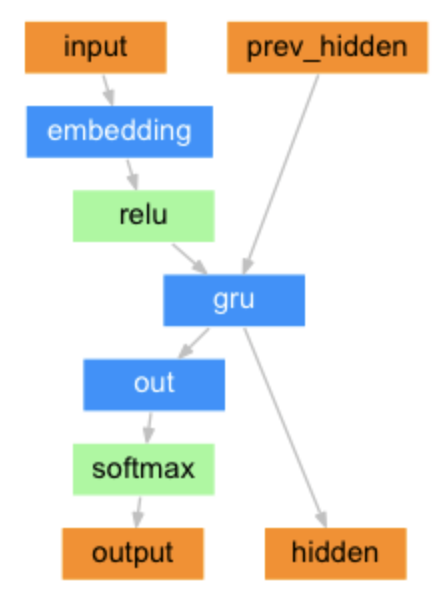

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
      super(DecoderRNN, self).__init__()
      self.hidden_size = hidden_size
      # Layers
      self.embedding = nn.Embedding(output_size, hidden_size)
      self.gru = nn.GRU(hidden_size, hidden_size)
      self.out = nn.Linear(hidden_size, output_size)
      self.softmax = nn.LogSoftmax(dim=1)

    
    def forward(self, input, hidden):
      output = self.embedding(input, hidden)
      output = F.relu(output)
      output, hidden = self.gru(output, hidden)
      ouptput = self.softmax(self.out(output[0]))    
      return output, hidden
    
    def initHidden(self):
      return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention Decoder
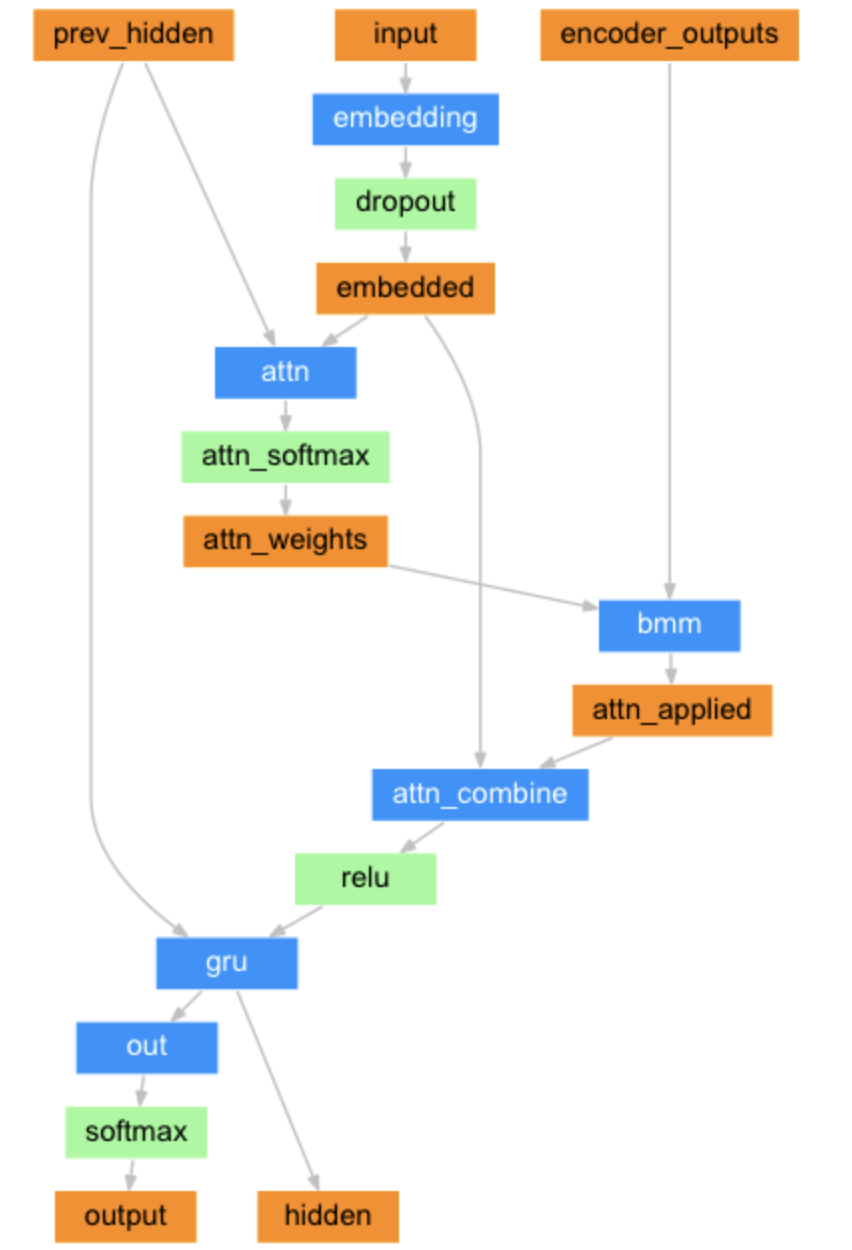

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        # Layers
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# 3) Training

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
random_index = np.random.randint(0,1000)
print("random_index :", random_index)
print("[[ pair ]]\n",pairs[random_index])
print("\n[[ tensor ]]\n", tensorsFromPair(pairs[random_index]))

random_index : 941
[[ pair ]]
 ['je suis deprime .', 'i m depressed .']

[[ tensor ]]
 (tensor([[  6],
        [ 11],
        [672],
        [  5],
        [  1]], device='cuda:0'), tensor([[  2],
        [  3],
        [371],
        [  4],
        [  1]], device='cuda:0'))


In [17]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # topk : i개의 가장 큰값들을 value와 index로 return함
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [18]:
### Helper Function


### 남은 시간과 진행률을 알려주는 함수
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### LOSS 그래프를 그려주는 함수
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [19]:
'''
전체 학습 과정

- 타이머 시작
- optimizers와 criterion 초기화
- 학습 쌍의 세트 생성
- 도식화를 위한 빈 손실 배열 시작
''' 
# 여러번 train을 호출해서 진행률과 평균 손실값을 출력함

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

1m 11s (- 16m 42s) (5000 6%) 2.8515
2m 19s (- 15m 7s) (10000 13%) 2.2945
3m 27s (- 13m 48s) (15000 20%) 1.9651
4m 35s (- 12m 38s) (20000 26%) 1.7522
5m 44s (- 11m 28s) (25000 33%) 1.5827
6m 52s (- 10m 18s) (30000 40%) 1.4175
8m 0s (- 9m 9s) (35000 46%) 1.2747
9m 9s (- 8m 0s) (40000 53%) 1.1402
10m 17s (- 6m 51s) (45000 60%) 1.0451
11m 26s (- 5m 43s) (50000 66%) 0.9279
12m 34s (- 4m 34s) (55000 73%) 0.8648
13m 43s (- 3m 25s) (60000 80%) 0.7884
14m 53s (- 2m 17s) (65000 86%) 0.7175
16m 3s (- 1m 8s) (70000 93%) 0.6706
17m 11s (- 0m 0s) (75000 100%) 0.6402


<Figure size 432x288 with 0 Axes>

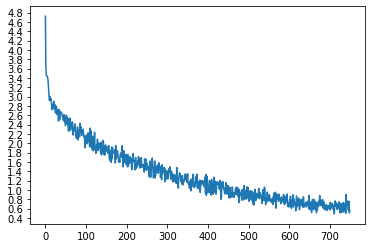

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

# 4) Evaluating

In [21]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [22]:
index = 10
print("[[ FRA / ENG ]] | index: {}\n".format(index))
print("### QUSETION ###")
print("{} >>> {}".format(pairs[index][0], pairs[index][1]))

print("### EVALUATE ###")
output_words, attentions = evaluate(encoder1, attn_decoder1, pairs[index][0])
output_sentence = ' '.join(output_words)
print("{} >>> {}".format(pairs[index][0], output_sentence))

[[ FRA / ENG ]] | index: 10

### QUSETION ###
je suis timide . >>> i m shy .
### EVALUATE ###
je suis timide . >>> i m shy . <EOS>


In [23]:
# 자동화 해주는 
def evaluateRandomly(encoder, decoder, n=10):
  for i in range(n):
    pair = random.choice(pairs)
    print("### START ###")
    print("> ", pair[0])
    print("= ", pair[1])

    output_words, attentions = evaluate(encoder, decoder, pair[0])
    output_sentence = ' '.join(output_words)
    print("< ",output_sentence)
    print("### END ###\n")

In [24]:
evaluateRandomly(encoder1, attn_decoder1)

### START ###
>  ce sont des chretiens .
=  they are christians .
<  they are christians . <EOS>
### END ###

### START ###
>  nous sommes fatigues .
=  we re tired .
<  we re tired . <EOS>
### END ###

### START ###
>  je ne suis pas ton serviteur .
=  i m not your servant .
<  i m not your servant . <EOS>
### END ###

### START ###
>  il ne faut pas nous deranger .
=  we are not to be disturbed .
<  we re not to be disturbed . <EOS>
### END ###

### START ###
>  nous partons maintenant .
=  we re leaving now .
<  we re leaving now . <EOS>
### END ###

### START ###
>  tu abuses de ton autorite .
=  you are abusing your authority .
<  you are abusing your authority . <EOS>
### END ###

### START ###
>  nous sommes la pour te proteger .
=  we re here to protect you .
<  we re here to protect you . <EOS>
### END ###

### START ###
>  je suis toujours inquiet .
=  i m still concerned .
<  i m always worried . <EOS>
### END ###

### START ###
>  t es givre !
=  you re nuts !
<  you re nut

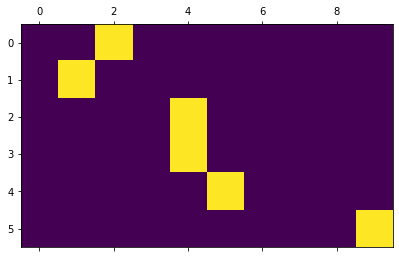

In [25]:
### Attention 시각화
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")

plt.matshow(attentions.numpy())

In [26]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


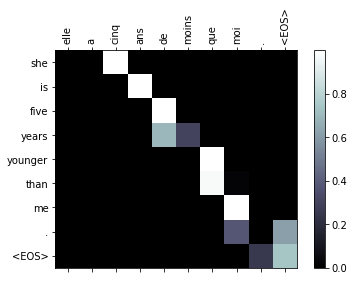

In [27]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

input = elle est trop petit .
output = she is too short . <EOS>


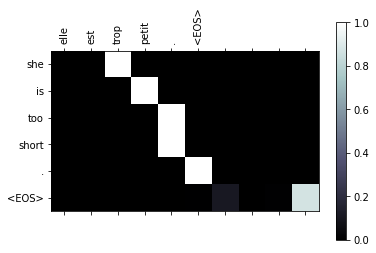

In [28]:
evaluateAndShowAttention("elle est trop petit .")

## Reference
* https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html